# Phase 0: Data Foundation

This notebook explores the chess data and verifies our preprocessing pipeline.

**Goals:**
1. Understand the data format
2. Verify the vocabulary makes sense
3. Test the DataLoader
4. Visualize character distributions

In [1]:
import sys
sys.path.append('../src')

import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

Matplotlib is building the font cache; this may take a moment.


## 1. Load and Examine the Data

In [2]:
data_dir = Path('../data/processed')

# Load training data
with open(data_dir / 'train.txt', 'r') as f:
    train_text = f.read()

# Load vocabulary
with open(data_dir / 'vocab.json', 'r') as f:
    vocab = json.load(f)

# Load stats
with open(data_dir / 'stats.json', 'r') as f:
    stats = json.load(f)

print(f"Training data: {len(train_text):,} characters")
print(f"Vocabulary size: {len(vocab)} tokens")
print(f"Number of games: {stats['num_train_games']:,}")

Training data: 483,999 characters
Vocabulary size: 29 tokens
Number of games: 4,500


In [3]:
# Look at sample games
games = train_text.split('\n')[:5]
for i, game in enumerate(games):
    print(f"Game {i+1}: {game[:80]}...")
    print(f"  Length: {len(game)} chars, {len(game.split())} moves")
    print()

Game 1: g3 e5 dxe5 b3 Nc3 Bc5 b6 Be2 b6 Bc4 O-O h6 Nf3 Kh8 Re1 Kh1 b3 b3 h3 Bb5 b6 h6 Qe...
  Length: 148 chars, 40 moves

Game 2: c4 c5 Bc4 d6 c6 Re1 Kh1 Qe2 Kh1 Bd3 Qd3 Nf3 Nxe5 Bc5 Be7 Re1 d6 Nxe5 c3 Bd6 Bc4 ...
  Length: 119 chars, 31 moves

Game 3: g3 d5 O-O-O Be2 exd5 Rad1 Be7 d3 d3 b3 Nf6 Nc3 Nxe5 Nf6 Re8 a6 Bxc6 Rfe8 Nf6 Nf6...
  Length: 102 chars, 25 moves

Game 4: d4 e6 Qe2 Qe7 b3 a3 Nxe5 Qd3 exd5 O-O Re1 Nxe5 Bg4 Nxe5 Rad8...
  Length: 60 chars, 15 moves

Game 5: g3 Nf6 Bc5 Bxc6 Bg5 Bc5 d3 d6 Re8 Nc3 Kh1 Qe7 Nf3 a3 Bb5 Bxc6 d6 c3 Rfe8...
  Length: 72 chars, 19 moves



## 2. Vocabulary Analysis

Understanding what characters the model will see.

In [4]:
print("Vocabulary:")
print("=" * 40)
for char, idx in sorted(vocab.items(), key=lambda x: x[1]):
    # Make special characters visible
    display_char = repr(char) if char in ['\n', ' '] else char
    print(f"  {idx:3d}: {display_char}")

Vocabulary:
    0: <pad>
    1: <sos>
    2: <eos>
    3: '\n'
    4: ' '
    5: -
    6: 1
    7: 2
    8: 3
    9: 4
   10: 5
   11: 6
   12: 7
   13: 8
   14: B
   15: K
   16: N
   17: O
   18: Q
   19: R
   20: a
   21: b
   22: c
   23: d
   24: e
   25: f
   26: g
   27: h
   28: x


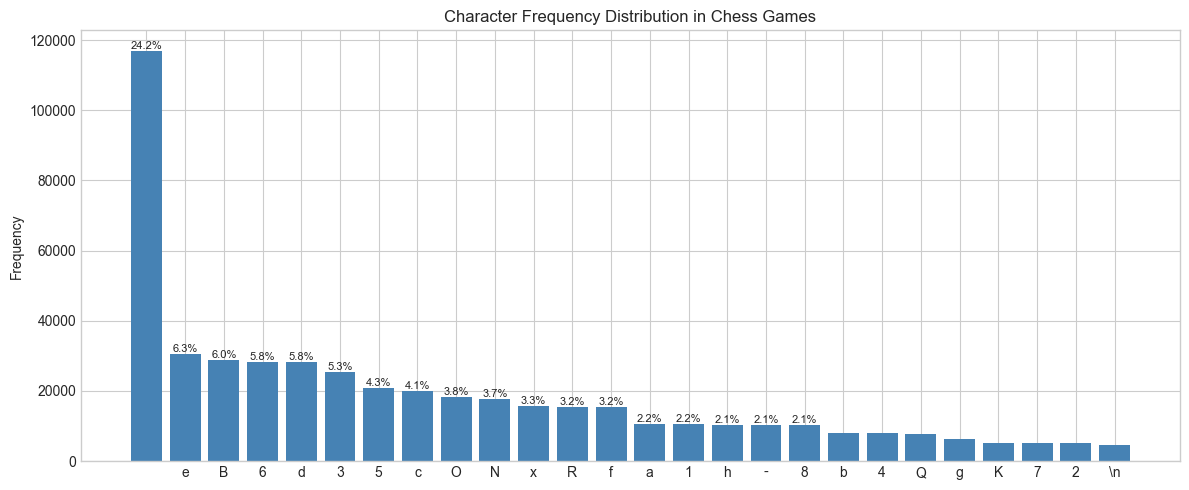

In [5]:
# Character frequency visualization
char_counts = Counter(train_text)

# Sort by frequency
chars = [c for c, _ in char_counts.most_common()]
counts = [char_counts[c] for c in chars]

# Make labels readable
labels = [repr(c)[1:-1] if c in ['\n', ' '] else c for c in chars]

fig, ax = plt.subplots(figsize=(12, 5))
bars = ax.bar(range(len(chars)), counts, color='steelblue')
ax.set_xticks(range(len(chars)))
ax.set_xticklabels(labels, fontsize=10)
ax.set_ylabel('Frequency')
ax.set_title('Character Frequency Distribution in Chess Games')

# Add percentage labels on top
total = sum(counts)
for bar, count in zip(bars, counts):
    pct = count / total * 100
    if pct > 2:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

### Character Categories

Let's group characters by their meaning in chess notation:

In [6]:
# Categorize characters
categories = {
    'Files (columns)': list('abcdefgh'),
    'Ranks (rows)': list('12345678'),
    'Pieces': list('KQRBN'),
    'Special': ['O', 'x', '-'],  # Castling, capture, castling separator
    'Structural': [' ', '\n']
}

for category, chars_in_cat in categories.items():
    total_cat = sum(char_counts.get(c, 0) for c in chars_in_cat)
    pct = total_cat / sum(char_counts.values()) * 100
    print(f"{category}: {pct:.1f}%")
    for c in chars_in_cat:
        if c in char_counts:
            display_c = repr(c)[1:-1] if c in ['\n', ' '] else c
            print(f"    {display_c}: {char_counts[c]:,}")

Files (columns): 26.7%
    a: 10,462
    b: 7,957
    c: 20,025
    d: 28,203
    e: 30,587
    f: 15,497
    g: 6,202
    h: 10,397
Ranks (rows): 23.5%
    1: 10,449
    2: 5,080
    3: 25,477
    4: 7,897
    5: 20,854
    6: 28,248
    7: 5,234
    8: 10,346
Pieces: 15.6%
    K: 5,243
    Q: 7,812
    R: 15,552
    B: 28,858
    N: 17,808
Special: 9.2%
    O: 18,190
    x: 15,847
    -: 10,364
Structural: 25.1%
     : 116,911
    \n: 4,499


## 3. Test the DataLoader

In [ ]:
import torch

# Check device
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using MPS (Apple Silicon GPU)


In [8]:
from dataset import ChessDataset, get_dataloaders
# Create dataset
BLOCK_SIZE = 128  # Context window

train_dataset = ChessDataset(
    data_path=str(data_dir / 'train.txt'),
    vocab_path=str(data_dir / 'vocab.json'),
    block_size=BLOCK_SIZE
)

Loaded 483,999 characters
Vocabulary size: 29
Block size: 128
Number of training examples: 483,870


In [26]:
train_dataset.data[0:100]  # View first 100 characters of training data

tensor([26,  8,  4, 24, 10,  4, 23, 28, 24, 10,  4, 21,  8,  4, 16, 22,  8,  4,
        14, 22, 10,  4, 21, 11,  4, 14, 24,  7,  4, 21, 11,  4, 14, 22,  9,  4,
        17,  5, 17,  4, 27, 11,  4, 16, 25,  8,  4, 15, 27, 13,  4, 19, 24,  6,
         4, 15, 27,  6,  4, 21,  8,  4, 21,  8,  4, 27,  8,  4, 14, 21, 10,  4,
        21, 11,  4, 27, 11,  4, 18, 24, 12,  4, 15, 27, 13,  4, 14, 24,  7,  4,
        15, 27,  6,  4, 19, 24,  6,  4, 19, 20])

In [23]:
# Get a sample
x, y = train_dataset[0]

print(f"Input shape: {x.shape}")
print(f"Target shape: {y.shape}")
print()
print("Input (first 64 chars):")
print(train_dataset.decode(x[:64]))
print()
print("Target (first 64 chars):")
print(train_dataset.decode(y[:64]))

Input shape: torch.Size([128])
Target shape: torch.Size([128])

Input (first 64 chars):
g3 e5 dxe5 b3 Nc3 Bc5 b6 Be2 b6 Bc4 O-O h6 Nf3 Kh8 Re1 Kh1 b3 b3

Target (first 64 chars):
3 e5 dxe5 b3 Nc3 Bc5 b6 Be2 b6 Bc4 O-O h6 Nf3 Kh8 Re1 Kh1 b3 b3 


In [27]:
# Verify target is shifted by 1
print("Alignment check:")
print(f"Input[1:10]:  '{train_dataset.decode(x[1:10])}'")
print(f"Target[0:9]:  '{train_dataset.decode(y[0:9])}'")
print(f"Match: {train_dataset.decode(x[1:10]) == train_dataset.decode(y[0:9])}")

Alignment check:
Input[1:10]:  '3 e5 dxe5'
Target[0:9]:  '3 e5 dxe5'
Match: True


In [28]:
# Test DataLoader
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

# Get a batch
batch_x, batch_y = next(iter(train_loader))
print(f"Batch input shape: {batch_x.shape}")
print(f"Batch target shape: {batch_y.shape}")
print(f"Expected: [batch_size, block_size] = [32, {BLOCK_SIZE}]")

Batch input shape: torch.Size([32, 128])
Batch target shape: torch.Size([32, 128])
Expected: [batch_size, block_size] = [32, 128]


## 4. Bigram Analysis (Baseline)

Before building a transformer, let's understand what a simple bigram model would see.
This gives us a baseline to beat.

In [29]:
# Build bigram counts
bigrams = Counter()
for i in range(len(train_text) - 1):
    bigrams[(train_text[i], train_text[i+1])] += 1

print(f"Unique bigrams: {len(bigrams):,}")
print(f"\nMost common bigrams:")
for (c1, c2), count in bigrams.most_common(15):
    display = f"'{c1 if c1 != ' ' else '⎵'}{c2 if c2 != ' ' else '⎵'}'"
    print(f"  {display}: {count:,}")

Unique bigrams: 93

Most common bigrams:
  '⎵B': 28,858
  '6⎵': 27,203
  '3⎵': 24,513
  '5⎵': 20,113
  '⎵N': 16,923
  '⎵R': 15,552
  'O-': 10,364
  '-O': 10,364
  '1⎵': 10,029
  '8⎵': 9,945
  '⎵d': 8,831
  'c6': 8,105
  'd3': 7,969
  '⎵O': 7,826
  '⎵Q': 7,812


/var/folders/2c/j77vrcg53_n5pfp0d47q_n2m0000gn/T/ipykernel_17928/2655882038.py:17: UserWarning: 'where' used without 'out', expect unitialized memory in output. If this is intentional, use out=None.
  bigram_probs = np.divide(bigram_matrix, row_sums, where=row_sums > 0)


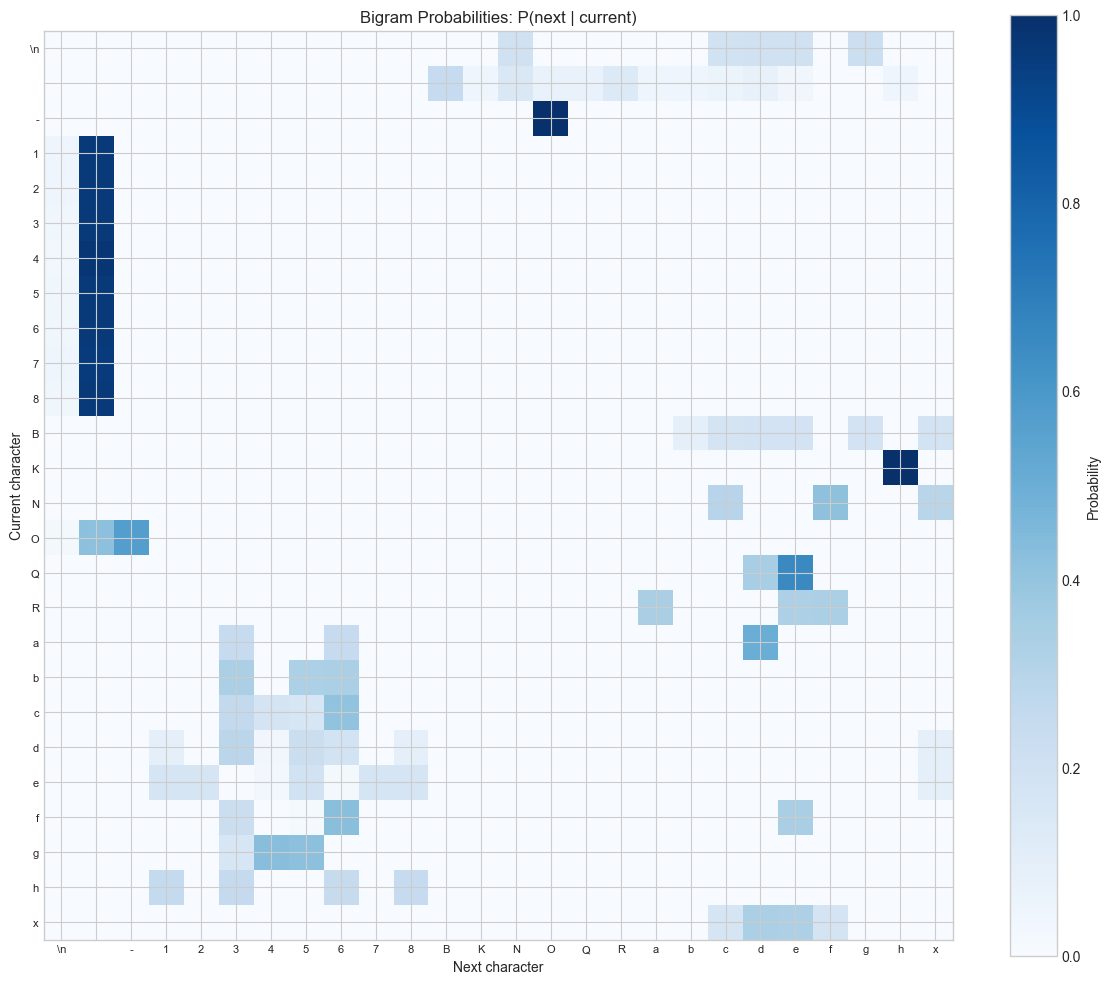

In [30]:
# Visualize bigram matrix
import numpy as np

# Get unique chars (excluding special tokens)
chars = sorted([c for c in vocab.keys() if not c.startswith('<')])
char_to_idx = {c: i for i, c in enumerate(chars)}
n_chars = len(chars)

# Build matrix
bigram_matrix = np.zeros((n_chars, n_chars))
for (c1, c2), count in bigrams.items():
    if c1 in char_to_idx and c2 in char_to_idx:
        bigram_matrix[char_to_idx[c1], char_to_idx[c2]] = count

# Normalize rows
row_sums = bigram_matrix.sum(axis=1, keepdims=True)
bigram_probs = np.divide(bigram_matrix, row_sums, where=row_sums > 0)

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(bigram_probs, cmap='Blues')

# Labels
labels = [repr(c)[1:-1] if c in ['\n', ' '] else c for c in chars]
ax.set_xticks(range(n_chars))
ax.set_yticks(range(n_chars))
ax.set_xticklabels(labels, fontsize=8)
ax.set_yticklabels(labels, fontsize=8)
ax.set_xlabel('Next character')
ax.set_ylabel('Current character')
ax.set_title('Bigram Probabilities: P(next | current)')

plt.colorbar(im, label='Probability')
plt.tight_layout()
plt.show()

## 5. Sample Generation (Bigram Baseline)

Let's see what random generation from bigrams looks like.
Our transformer should eventually do much better.

In [31]:
def generate_bigram(start_char, length, bigram_probs, chars, temperature=1.0):
    """Generate text using bigram probabilities."""
    char_to_idx = {c: i for i, c in enumerate(chars)}
    
    result = [start_char]
    current = start_char
    
    for _ in range(length - 1):
        if current not in char_to_idx:
            current = ' '  # Default to space
        
        probs = bigram_probs[char_to_idx[current]].copy()
        
        # Apply temperature
        if temperature != 1.0:
            probs = probs ** (1 / temperature)
        
        # Normalize
        if probs.sum() > 0:
            probs = probs / probs.sum()
        else:
            probs = np.ones(len(chars)) / len(chars)
        
        # Sample
        next_idx = np.random.choice(len(chars), p=probs)
        next_char = chars[next_idx]
        result.append(next_char)
        current = next_char
    
    return ''.join(result)

# Generate samples
print("Bigram-generated 'chess games':")
print("=" * 50)
for i in range(3):
    sample = generate_bigram('e', 100, bigram_probs, chars, temperature=0.8)
    print(f"Sample {i+1}: {sample}")
    print()

Bigram-generated 'chess games':
Sample 1: exc3 Bxe5 d5 Bd5 Bg5 d3 Bg4 h6 Nf6 Nfe2 d5 Nc3 Nfe8 Qd6 Re8 d3 d3 Nc6 Bd5 Re5 d8 Nf6 Qe2 Bxc4 a3 Bg5

Sample 2: e2 Bd3 Nf3 e4 Kh1 Bc4 d5 Bg5 Bd5 Qe5 Bg5 Bc6 Bg4 O-O d6 Qe2 c6 h8 Bd6 Bxf3 Bd6 Be7 Nxc6 Be7 Rad6 e1 

Sample 3: e4 Bg3 Rad3 c6 Qd5 h3 Be1 Bxdxc6 c6 Be2 Qd3 Re6 d3 Rad6 d5 h1 Qe8 a3 d6 e2 Re7 Bg5 Nxe5 c4 Re2 h6 Nf



## Summary

**Data characteristics:**
- ~26-30 unique characters (small vocabulary!)
- Strong structural patterns (pieces, squares, captures)
- Spaces are very common (~24%)
- Each game is a sequence of moves

**What makes this good for learning:**
1. Small vocabulary = less parameters needed for embeddings
2. Clear structure = attention patterns should be interpretable
3. Legal move sequences = we can validate outputs

**Bigram baseline:**
- Produces plausible-looking fragments
- But clearly not real chess moves
- No long-range dependencies (can't remember what pieces are where)

**Next: Phase 1 - Embeddings**